In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
import tqdm

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
#from yellowbrick.model_selection import FeatureImportances
import matplotlib.gridspec as gridspec
#from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Shortcut to duplicate current line

In [4]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);


<IPython.core.display.Javascript object>

In [2]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

In [3]:
selected_columns
tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

In [4]:
tw.head()

,UHRSWORK,OCC,DEGFIELDD,EDUC,WKSWORK2,VALUEH,OWNCOST,DEGFIELD,EDUCD,AGE,...,WRKLSTWK,PWMET13,REGION,EMPSTATD,WORKEDYR,CBPERNUM,PWMET13ERR,YNGCH,BEDROOMS,>50K
1824313,45.0,4760.0,0.0,7.0,6.0,535000.0,2372.0,0.0,71.0,25.0,...,2.0,35620.0,12.0,10.0,3.0,4.0,2.0,99.0,5.0,0.0
1130558,40.0,4810.0,0.0,4.0,6.0,250000.0,2778.0,0.0,40.0,79.0,...,2.0,23060.0,21.0,10.0,3.0,1.0,6.0,99.0,4.0,1.0
62170,40.0,9645.0,0.0,6.0,6.0,100000.0,1365.0,0.0,64.0,50.0,...,2.0,38060.0,41.0,10.0,3.0,2.0,4.0,14.0,5.0,0.0
1322200,50.0,6305.0,0.0,7.0,6.0,40000.0,987.0,0.0,71.0,46.0,...,2.0,0.0,11.0,10.0,3.0,1.0,0.0,99.0,3.0,0.0
687018,40.0,8255.0,0.0,6.0,6.0,250000.0,960.0,0.0,63.0,54.0,...,2.0,34940.0,31.0,10.0,3.0,1.0,1.0,99.0,4.0,0.0


In [5]:
X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K'])

In [6]:
Z = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])
Zs = tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])

In [7]:
categorical_features = ['EDUC', 'DEGFIELD', 'SEX', 'OCC']
continuous_features = ['UHRSWORK', 'VALUEH', 'AGE', 'TRANWORK']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

train_df = X_train.copy()
train_df['$$$'] = y_train

Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

In [9]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)

Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

len(Xs_train)

40000

## KNN With regular X nonscaled
Full dataset, takes too long for quick testing. Save for final product

In [10]:
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)
# print("The score for kNN is")
# print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
# print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

## KNN with Xs

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xs_train, ys_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Xs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Xs_test, ys_test)))

<ipython-input-11-07a8951d040d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


The score for kNN is
Training:  75.64%
Test set:  64.44%


## KNN with scaled Xs 

\~ takes forever for some reason \~

In [12]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Xs_train_scaled, ys_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Xs_train_scaled[:100], ys_train[:100])))
print("Test set: {:6.2f}%".format(100*knn.score(Xs_test[:100], ys_test[:100])))

<ipython-input-12-5d64283cb0b9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN is
Training:  92.00%
Test set:  64.00%


## KNN with small feature set sample (Zs) scaled

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Zs_train_scaled, qs_train)
print("Training: {:6.2f}%".format(100*knn.score(Zs_train_scaled, qs_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, qs_test)))

<ipython-input-13-d65cfc3f2cfb>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  85.43%
Test set:  65.17%


## KNN with small feature set Zs unscaled

### \~\~\~ *one of the best tried yet* \~\~\~

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Zs_train, qs_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Zs_train, qs_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, qs_test)))

The score for kNN is


<ipython-input-14-be8dd8461117>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train, qs_train)


Training:  81.77%
Test set:  73.51%


## Logistic Regression with Xs non-scaled 

In [15]:
logit = LogisticRegression(C = 0.95)
logit.fit(Xs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Xs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Xs_test, ys_test)))

The score for logistic regression is
Training:  69.08%
Test set:  68.61%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic Regression Xs scaled with varying regularization strengths 
(The varying regularization strengths actually seem to have no effect)

In [16]:
Cs = [0.5, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

for c in Cs:
    logit = LogisticRegression(C = c)
    logit.fit(Xs_train_scaled, ys_train)
    print(f"The score for logistic regression with C = {c} is")
    print("Training: {:6.2f}%".format(100*logit.score(Xs_train_scaled, ys_train)))
    print("Test set: {:6.2f}%".format(100*logit.score(Xs_test, ys_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 0.5 is
Training:  81.84%
Test set:  65.98%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 1 is
Training:  81.85%
Test set:  66.05%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 10 is
Training:  81.85%
Test set:  66.01%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 100 is
Training:  81.86%
Test set:  66.01%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 1000 is
Training:  81.86%
Test set:  66.01%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 10000 is
Training:  81.86%
Test set:  66.01%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 100000 is
Training:  81.86%
Test set:  66.00%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 1000000 is
Training:  81.86%
Test set:  66.00%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 10000000 is
Training:  81.86%
Test set:  66.00%


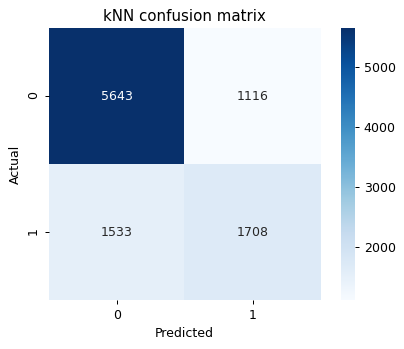

In [17]:
knn_confusion = confusion_matrix(ys_test, knn.predict(Zs_test))
plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [18]:
# from imblearn.under_sampling import CondensedNearestNeighbour


# cnn = CondensedNearestNeighbour()

# # X_resampled, y_resampled = cnn.fit_resample(X, y)
# # Xs_resampled, ys_resampled = cnn.fit_resample(Xs, ys)
# # Z_resampled, y_resampled = cnn.fit_resample(Z, y)
# Zs_resampled, ys_resampled = cnn.fit_resample(Zs, ys)

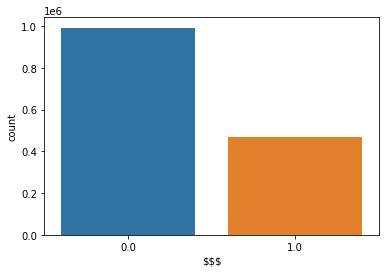

In [19]:
sns.countplot(train_df['$$$'])

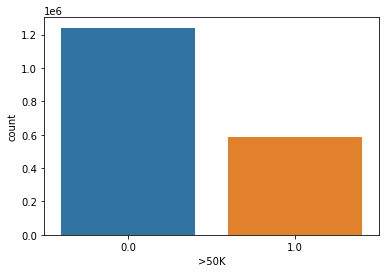

In [20]:
sns.countplot(y['>50K'])

#### Slightly unbalanced -- try undersampling. We don't want random undersampling - Condensed Nearest Neighbor looks good!

In [21]:
# sns.countplot(y_resampled['>50K'])

In [22]:
logit = LogisticRegression(C = 0.95)
logit.fit(Xs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The score for logistic regression is
Training:  68.93%
Test set:  68.97%


In [23]:
# logit = LogisticRegression(C = 0.95)
# logit.fit(Xs_resampled, ys_resampled)
# print("The score for logistic regression is")
# print("Training: {:6.2f}%".format(100*logit.score(Xs_resampled, ys_resampled)))
# print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

In [24]:
# using the default threshold of 0.5, which is what vanilla predict does
ys_predict = knn.predict(Zs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6048,   Recall: 0.5270


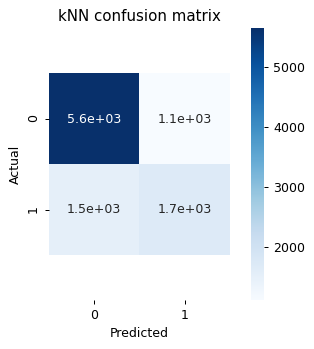

In [25]:
knn_confusion = confusion_matrix(ys_test, knn.predict(Zs_test))
fig, ax = plt.subplots(dpi=90)
#plt.figure()
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

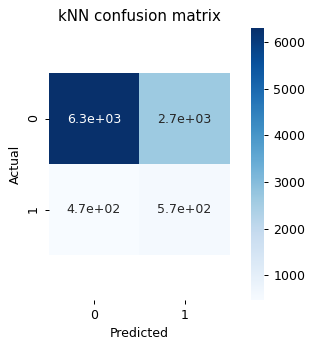

In [26]:
knn_confusion = confusion_matrix(logit.predict(Xs_test), ys_test)
fig, ax = plt.subplots(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [27]:
fbeta_score(ys_test, ys_predict, average=None, beta=0.5)

array([0.79561797, 0.58746646])

In [28]:
logit.coef_

array([[ 1.16337026e-06, -4.45060256e-05,  4.90977431e-08,
         1.34033064e-07,  4.93353852e-07,  1.61433440e-05,
         9.63982216e-07, -5.17333800e-07,  5.54079813e-05,
         2.64706572e-07,  7.79875306e-07,  1.83855417e-05,
        -1.07722529e-05,  3.06381928e-06,  1.19739023e-05,
         9.04875826e-09,  3.96732827e-05, -3.14639420e-05,
        -5.71704367e-09, -2.87423889e-05, -3.58859502e-08,
        -1.18343277e-05, -4.94823608e-08, -9.48225881e-07,
        -3.01469715e-05, -6.81953634e-07, -9.46413157e-08,
        -5.14139045e-06,  2.68741310e-09,  1.63191829e-06,
        -3.21061911e-08,  1.08344471e-07,  4.37371721e-08,
        -6.04219916e-05,  1.08041977e-05,  3.52103103e-07,
        -7.51341910e-08,  2.42468501e-07,  4.23467669e-10,
        -4.63841594e-07,  1.43671442e-08, -6.38723609e-08,
        -1.84781133e-06, -4.25959832e-08]])

In [29]:
X.columns

Index(['UHRSWORK', 'OCC', 'EDUC', 'WKSWORK2', 'VALUEH', 'OWNCOST', 'DEGFIELD',
       'AGE', 'PWPUMA00', 'PROPTX99', 'TRANTIME', 'MORTAMT1', 'DENSITY',
       'PROPINSR', 'ARRIVES', 'METPOP10', 'IND', 'PUMA', 'HIUID', 'COSTELEC',
       'SEX', 'ANCESTR1', 'ROOMS', 'BPL', 'COSTWATR', 'STATEICP', 'RELATE',
       'MET2013', 'STATEFIP', 'PWCOUNTY', 'BUILTYR2', 'COUNTYFIP', 'MOVEDIN',
       'COSTGAS', 'DEPARTS', 'TRANWORK', 'EMPSTAT', 'CLASSWKRD', 'WRKLSTWK',
       'REGION', 'WORKEDYR', 'CBPERNUM', 'YNGCH', 'BEDROOMS'],
      dtype='object')

In [30]:
Z.columns

Index(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX',
       'TRANWORK'],
      dtype='object')

<a class="anchor" id="compare"></a>
**KTAS expert vs KTAS RN**

Looks like UHRSWORK and EDUC are the main indicators. Let's see for UHRSWORK how accurate of a prediction we get

In [31]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Zs_train, ys_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Zs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, ys_test)))

<ipython-input-31-cf8ad713e856>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train, ys_train)


The score for kNN is
Training:  81.77%
Test set:  73.51%


Simple logistic regression looking the best! Below. Highest r2 on test data yet!

In [32]:
logit = LogisticRegression(C = 0.95)
logit.fit(Zs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Zs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Zs_test, ys_test)))

The score for logistic regression is
Training:  75.42%
Test set:  75.30%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Yikes... with scaling the test r2 goes down to 32%!! Why?

In [33]:
logit = LogisticRegression(C = 0.95)
logit.fit(Zs_train_scaled, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Zs_train_scaled, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Zs_test, ys_test)))

The score for logistic regression is
Training:  79.97%
Test set:  32.99%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


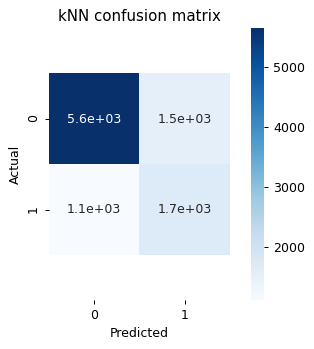

In [34]:
knn_confusion = confusion_matrix(knn.predict(Zs_test), ys_test)
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [35]:
ys_predict = knn.predict(Zs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6048,   Recall: 0.5270


In [36]:
logit.coef_

array([[ 0.84533833,  1.44901736, -0.3411666 ,  0.24730149, -0.0071022 ,
         0.72740059, -0.47874411,  0.03517425]])

<a class="anchor" id="metrics"></a>
## Metrics

Accuracy:% obs correctly classified/all observations

Precision: How many selected items are relevant?

Recall:How many relevant items are selected?

F1 Score: Harmonic mean b/w precision & recall

Confusion Matrix: Accuracy by class

ROC Curve: Sensitivity vs specificity

<img src=https://www.digital-mr.com/media/cache/5e/b4/5eb4dbc50024c306e5f707736fd79c1e.png width="650">

<img src=https://miro.medium.com/max/722/1*pk05QGzoWhCgRiiFbz-oKQ.png width="250">

<img src=https://newbiettn.github.io/images/confusion-matrix-noted.jpg width="250">

**TPR** = true positive rate = sensitivity

**FPR** = false positive rate = specificity

**Confusion Matrix Above**

True Negative  | False Positive

False Negative | True Positive

 0Acutal 0pred  | 0Actual 1pred
 
 1Actual 0pred  | 1Actual 1pred


**My model**

Right now precision is better than recall. The model is also often predicting discharge, because there is class imbalance. 

Precision: Truly admitted / truly admitted + we predicted they would be admitted and they were not
Recall: Truly admitted/ truly admitted + we predicted they would not be admitted but they were 

Recall is more important in my case. I want to capture all those admitted. If we guess a few to be admitted, but they aren't that isn't as pertinent. In that case we're just over-allocating some resources. Would be nice to have both, though.

FBeta: Setting an fbeta above 1 allows for the model to prioritize recall, so I'm going to see if 2,3, or 4 work.

<a class="anchor" id="features"></a>
## Feature Engineering

Feature Enginering and Selection in Linked Notebook:

- [Feature Engineering](project_3_features.ipynb)
- [Prelim Models](#prelim)

Results of Feature Engineering:

- Dummy variables for categoricals
- Most vitals did not follow a normal distribution, so I binned them into low, normal, high (for ex.)

In [37]:
train_df.head()

,UHRSWORK,OCC,EDUC,WKSWORK2,VALUEH,OWNCOST,DEGFIELD,AGE,PWPUMA00,PROPTX99,...,TRANWORK,EMPSTAT,CLASSWKRD,WRKLSTWK,REGION,WORKEDYR,CBPERNUM,YNGCH,BEDROOMS,$$$
1971391,0.0,0.0,4.0,0.0,80000.0,228.0,0.0,16.0,0.0,22.0,...,0.0,3.0,0.0,1.0,12.0,1.0,3.0,99.0,6.0,0.0
2804169,45.0,7220.0,6.0,6.0,100000.0,1148.0,0.0,56.0,3800.0,32.0,...,10.0,1.0,22.0,2.0,33.0,3.0,1.0,31.0,5.0,1.0
62430,0.0,0.0,11.0,0.0,2387000.0,1087.0,23.0,78.0,0.0,65.0,...,0.0,3.0,0.0,1.0,41.0,1.0,2.0,99.0,4.0,1.0
1226121,40.0,5240.0,6.0,6.0,1100.0,698.0,0.0,55.0,500.0,54.0,...,10.0,1.0,23.0,2.0,22.0,3.0,1.0,99.0,4.0,0.0
2131220,0.0,0.0,10.0,0.0,370000.0,561.0,23.0,71.0,0.0,27.0,...,0.0,3.0,0.0,1.0,31.0,1.0,2.0,99.0,5.0,0.0


<a class="anchor" id="prelim"></a>
**Prelim Models After Feature Engineering**

- No cross validation
- Only logistic and knn

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Zs_train, ys_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Zs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, ys_test)))

<ipython-input-39-cf8ad713e856>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train, ys_train)


The score for kNN is
Training:  81.77%
Test set:  73.51%


In [41]:
logit = LogisticRegression(C = 0.95)
logit.fit(Zs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Zs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Zs_test, ys_test)))

The score for logistic regression is
Training:  75.42%
Test set:  75.30%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


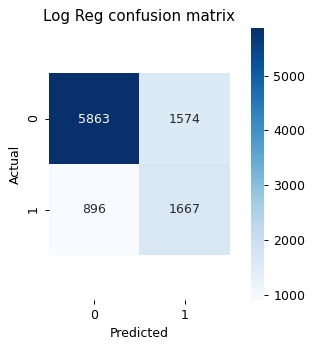

In [44]:
logit_confusion = confusion_matrix(logit.predict(Zs_test), ys_test)
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Log Reg confusion matrix');

In [48]:
ys_predict = logit.predict(Zs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6504,   Recall: 0.5143


In [49]:
logit.coef_

array([[-7.76838109e-04,  3.12228404e-02, -2.09856791e-04,
         1.24918521e-07,  1.97402977e-02, -2.35058081e-02,
        -1.55037541e-03,  8.47399437e-03]])

In [51]:
Zs_train.columns

Index(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX',
       'TRANWORK'],
      dtype='object')

Definitely an improvement! Recall looking quite a bit better. Going to try a few more models tomorrow to check out the rest

<a class="anchor" id="modfunctions"></a>
## Functions (Model Selection Pipeline)

Things to address in pipeline:
- Class Imbalance
- Kfold cross validation (small dataset)
- Metrics selected above (recall important)
- ROC Curve

In [5]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X, Xs, y, ys, Z, Zs = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K']), selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

train_df = Zs_train.copy()
train_df['$$$'] = ys_train

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)
Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

In [9]:
def models(X,y,resampler):
    '''
    This function takes features, predictors, and a resampling method. It splits into train and test then
    cross validates on the training set using kfolds = 5. Train test split and kfolds are stratified to 
    ensure representation of classes in the test set. Output is the FBeta score for each model (beta = 4)
    prioritizing for recall. Also outputs ROC curve including all models
    ------
    Inputs: array, series, over_sampler (ADASYN, SMOTE, or RandomOverSampling)
    Outputs: dictionary, plot
    
    '''
    # 80:20 split holding out test set. Calling kfold
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
    kf = StratifiedKFold(n_splits=5, shuffle = True)

    # Dictionary to hold Results
    cv_results = defaultdict()
    cv_accuracy = defaultdict()
    test_results = defaultdict()

    # Get indices for split
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Couple models
    models = {'logreg':LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear'), 
             'knn': KNeighborsClassifier(),
             'svc': svm.SVC(gamma = 'scale', probability = True),
             'naive': BernoulliNB(),
             'dectree': DecisionTreeClassifier(),
             'forrest': RandomForestClassifier(n_estimators = 100),} 
             #'xgboost': XGBClassifier()}

    for model_name, model in models.items():
        cv_results[model_name] = []
        cv_accuracy[model_name] = []
        
        for indices in kf.split(X_train, y_train):
            train_ind = indices[0]
            val_ind = indices[1]
            X_tr, y_tr = X_train[train_ind], y_train[train_ind]
            X_resampled_train, y_resampled_train = resampler().fit_resample(X_tr, y_tr)
            X_val, y_val = X_train[val_ind], y_train[val_ind]
            X_resampled_val, y_resampled_val = resampler().fit_resample(X_val, y_val)
            model.fit(X_resampled_train, y_resampled_train)
            y_pred = model.predict(X_val)
            cv_results[model_name].append(fbeta_score(y_val, y_pred,4))
            cv_results[model_name].append('Precision Score {:.2f}'.format(precision_score(y_val, y_pred)))
            cv_results[model_name].append('Recall Score: {:.2f}'.format(recall_score(y_val, y_pred)))
            cv_results[model_name].append('F1 Score: {:.2f}'.format(f1_score(y_val, y_pred)))
            cv_results[model_name].append('Training Accuracy:{:6.2f}%'.format(100*model.score(X_train, y_train)))
            cv_results[model_name].append('Validation Accuracy: {:6.2f}%'.format(100*model.score(X_val, y_val)))

            cv_accuracy[model_name].append(100*model.score(X_val, y_val))
            
    fig = plt.figure(figsize=(10,10))    
    for model_name, model in models.items():
        cv_results[model_name] = 'Mean FBeta Score: {:.2f}'.format(statistics.mean(cv_results[model_name]))
        cv_accuracy[model_name] = 'Mean Val Accuracy: {:6.2f}%'.format(statistics.mean(cv_accuracy[model_name]))
        test_results[model_name] = 'Test Accuracy: {:6.2f}%'.format(100*model.score(X_test, y_test))
        fpr, tpr, threshold_curve = roc_curve(ys_test, model.predict_proba(X_test)[::,1])
        plt.plot(fpr, tpr,lw=2, color =np.random.rand(3,), label = model_name)
        plt.legend()
        plt.plot([0,1],[0,1],c='violet',ls='--')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve for All Models');
    return cv_results, cv_accuracy, test_results

<a class="anchor" id="modelselection"></a>
## Model Selection

**Near Miss Undersampling**

In [ ]:
from imblearn.under_sampling import NearMiss

nm1 = NearMiss(version=1)

# models(Z_train, y_train, NearMiss)

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=4 as keyword args. From version 0.25 passing these as positional arguments will result in an 

**Undersampling**

In [ ]:
models(X,y,ADASYN)

**Methods**

In [ ]:
models(X,y,SMOTE)

^^^ Change oversampling methods above to undersampling for below 50k! ^^^

**Taking Out KTAS**

In [ ]:
X_dktas = X.drop([2,3,4,5], axis = 1)

In [ ]:
models(X_dktas,y, ADASYN)

**Local vs Regional Hospital**

In [ ]:
df_region = df_fe[df_fe['hospital'] == 1].reset_index()
df_local = df_fe[df_fe['hospital'] == 0].reset_index()

In [ ]:
X_local = df_local.drop(['hospital','admissions', 'index'], axis = 1)
y_local = df_local['admissions']
X_region = df_region.drop(['hospital','admissions', 'index'], axis = 1)
y_region = df_region['admissions']

In [ ]:
models(X_local, y_local, RandomOverSampler)

In [ ]:
models(X_region, y_region, RandomOverSampler)

Looks like the model is better at perfoming in the regional hospital... so I did some research:

Study setting
We selected 1 regional and 1 local ED based on a number of factors, including patient visits per year, the presence of emergency nurses dedicated to triage only, and collection possibility of the selected variables. Both EDs were academic urban medical centers. The regional ED had approximately 45,000 patient visits per year, and the local ED had approximately 40,000 patient visits per year. Both EDs were divided into a triage area at the entrance and a treatment area. In the regional ED, emergency nurses and doctors took a medical history and performed a physical examination together. The data collected were recorded in the initial nursing record and the doctor’s record, respectively. In the local ED, an emergency nurse conducted a physical examination alone. Initial nursing records from the two EDs included chief complaint, onset time, arrival mode, underlying disease, vital signs, oxygen saturation, surgical history, mental state, pain score, medication and allergy history. The pain scale used in the two EDs was the Numeric Rating Scale (NRS) which consists of a patient self-reporting 11-point scale.

Let's see if I take out KTAS which is better

In [ ]:
X_local_dktas = X_local.drop([2,3,4,5], axis = 1)
X_region_dktas = X_region.drop([2,3,4,5], axis = 1)

**Performance by Hospital without KTAS**

In [ ]:
models(X_local_dktas, y_local, SMOTE)

In [ ]:
models(X_region_dktas, y_region, SMOTE)

<a class="anchor" id="gridsearch"></a>
## Grid Search CV

**Logistic Regression**

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
logreg = LogisticRegression()
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(Zs_train, ys_train)    
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Think about vif individual features

<a class="anchor" id="logfunctions"></a>
## Logistic Regression Functions

In [ ]:
def logregPlots(X,y, resampler):
    # Fit logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
    
    # Stratify ensures minority class is represented in both sets in 80:20 ratio
    logit = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')
    
    # Get indices for split
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    cv_results = []
    for indices in kf.split(X_train, y_train):
        train_ind = indices[0]
        val_ind = indices[1]
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_resampled_train, y_resampled_train = resampler(random_state=42).fit_sample(X_tr,y_tr)
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        X_resampled_val, y_resampled_val = resampler(random_state=42).fit_sample(X_val, y_val)
        logit.fit(X_resampled_train, y_resampled_train)
        y_pred = logit.predict(X_val)
        cv_results.append(#'Precision Score {:.2f}'.format(precision_score(y_val, y_pred)),
                                  #'Recall Score: {:.2f}'.format(recall_score(y_val, y_pred)), 
                                  #'F1 Score: {:.2f}'.format(f1_score(y_val, y_pred)), 
                                #'Training Accuracy:{:6.2f}%'.format(100*model.score(X_train, y_train)),
                                #'Validation Accuracy: {:6.2f}%'.format(100*model.score(X_val, y_val)),
                                 fbeta_score(y_val, y_pred,4))
    cv_results = 'Training FBeta Score: {:.2f}'.format(statistics.mean(cv_results))
    
    # Start Figure
    fig = plt.figure(figsize = (15,15))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    plt.rcParams.update({'font.size': 14})
    plt.rc('axes', titlesize = 14, labelsize = 14)
        
    # Make predictions on y_test
    logit_confusion = confusion_matrix(logit.predict(X_test), y_test)
    ax1 = fig.add_subplot(spec[0,0])
    sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True)
    bottom, top = ax1.get_ylim()
    ax1.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Log Reg Confusion Matrix');
    
    #ROC Curve
    ax2 = fig.add_subplot(spec[0,1])
    fpr, tpr, threshold_curve = roc_curve(y_test, logit.predict_proba(X_test)[:,1] )
    plt.plot(fpr, tpr,lw=2, color = 'navy')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve for Logistic Regression');
    
    # Feature Importance
    ax3 = fig.add_subplot(spec[1,0])
    viz = FeatureImportances(logit, labels = ['Elderly', 'Middle Age', 'High BT', 
                                              'Gender', 'High RR', colormap = plt.cm.RdBu)
    viz.fit(X, y)
    plt.title('Feature Importance of 20 Features')
    plt.xlabel('Relative Coefficient Magnitude')

    # Precision/Recall Curve
    ax4 = fig.add_subplot(spec[1,1])
    pc, rc, threshold_curve = precision_recall_curve(y_test, logit.predict_proba(X_test)[:,1])
    plt.plot(threshold_curve, pc[:-1], lw = 2, label = 'Precision', color = 'navy')
    plt.plot(threshold_curve, rc[:-1], lw = 2, label = 'Recall', color = 'navy')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision/Recall Curve for Logistic Regression');
    
    # Position Subplots
    #plt.subplots_adjust(right = 2.2, top = 1, wspace = 0.5)
    
    #Metrics
    plt.savefig("logreg.png")
    print("ROC AUC score = ", roc_auc_score(y_test, logit.predict_proba(X_test)[:,1]))
    return cv_results

In [ ]:
def logregMetrics(X,y,resampler):
    # 80:20 split holding out test set. Calling kfold
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)
    kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

    # Get indices for split
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Couple models
    log_reg = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')
    
    for train_ind, val_ind in kf.split(X_train, y_train):
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_resampled_train, y_resampled_train = resampler(random_state=42).fit_sample(X_tr,y_tr)
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        X_resampled_val, y_resampled_val = resampler(random_state=42).fit_sample(X_val, y_val)
        log_reg.fit(X_resampled_train, y_resampled_train)
        y_pred = log_reg.predict(X_val)
        training_result = ('Training Precision Score {:.2f}'.format(precision_score(y_val, y_pred)),
                                  'Training Recall Score: {:.2f}'.format(recall_score(y_val, y_pred)), 
                                  #'F1 Score: {:.2f}'.format(f1_score(y_val, y_pred)), 
                                 'Training FBeta Score: {:.2f}'.format(fbeta_score(y_val, y_pred,2)))
    y_pred_test = log_reg.predict(X_test)
    test_result = ('Test Precision Score {:.2f}'.format(precision_score(y_test, y_pred_test)),
                                  'Test Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_test)), 
                                  #'F1 Score: {:.2f}'.format(f1_score(y_val, y_pred)), 
                                 'Test FBeta Score: {:.2f}'.format(fbeta_score(y_test, y_pred_test,2)))

    return training_result, test_result

<a class="anchor" id="logregperf"></a>
## Logistic Regression Performance

In [ ]:
logreg(X,y, SMOTE)

In [ ]:
logregPlots(X,y, SMOTE)

In [ ]:
logregPlots(X_dktas, y, ADASYN)

<a class="anchor" id="pickle"></a>
## Pickling the Model for Flask

In [ ]:
pwd

In [ ]:
def logregPickle(X,y):
    log_reg = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')
    log_reg.fit(X,y)
    log_reg.feature_names = X.columns
    log_reg.target_names = ['Not Admitted', 'Admitted']
    with open('project_3/website/model.pkl', 'wb') as to_write:
        pickle.dump(log_reg, to_write)

In [ ]:
logregPickle(X,y)

<a class="anchor" id="predict"></a>
## Checking Predictions

In [ ]:
pwd

In [ ]:
with open('website/model.pkl', 'rb') as read_file:
    lr_model = pickle.load(read_file)

In [ ]:
lr_model.feature_names

In [ ]:
lr_model.predict([[0,1,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0]])

In [ ]:
lr_model.predict_proba([[0,1,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0]])

In [ ]:
lr_model.target_names

In [ ]:
pred_probs = lr_model.predict_proba([[0,1,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0]])

In [ ]:
pred_probs

In [ ]:
for index in np.argsort(pred_probs)[::-1]:
    print(index)

In [ ]:
feature_names = lr_model.feature_names
feature_dict = dict((feature,0) for feature in feature_names)

In [ ]:
feature_dict

In [ ]:
feature_dict['sex'] = 1

In [ ]:
x_input = [
        float(feature_dict.get(name, 0)) for name in lr_model.feature_names
    ]

In [ ]:
feature_dict = dict((feature,0) for feature in lr_model.feature_names)

In [ ]:
for name in lr_model.feature_names:
    print(feature_dict[name])